<a href="https://colab.research.google.com/github/DanieleAngioni97/Introductory-Seminar-PyTorch/blob/main/notebooks/04_nlp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Character-level generation with RNNs

# Data preparation

In [83]:
# data: https://download.pytorch.org/tutorial/data.zip
import io
import os
import unicodedata
import string
import requests
import zipfile
import torch
import random

## Defining the alphabet and the preprocessing

First, we define the set of all letters as the ASCII characters.

In [91]:
# alphabet small + capital letters + " .,;'"
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)
EOS = '.'

print(f"Number of letters: {N_LETTERS}")
print(f"All letters: \n{ALL_LETTERS}")

Number of letters: 57
All letters: 
abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


In [92]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS)

print(f"Unicode: 'Ślusàrski' ---> ASCII: {unicode_to_ascii('Ślusàrski')}")

Unicode: 'Ślusàrski' ---> ASCII: Slusarski


## Converting a letter to an index

In [93]:
# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.index(letter)

print(letter_to_index('h'))
print(letter_to_index('e'))
print(letter_to_index('l'))
print(letter_to_index('l'))
print(letter_to_index('o'))

7
4
11
11
14


In [94]:
def line_to_index(line):
    return [letter_to_index(l) for l in line]

print(line_to_index('hello'))

[7, 4, 11, 11, 14]


In [96]:
# turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor
tensor = letter_to_tensor('a')
print(tensor)
print(tensor.shape)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([1, 57])


In [125]:
# Turn a line a tensor with the one-hot encodings of each letter

def line_to_tensor(line):
    tensor = torch.zeros(1, len(line), N_LETTERS)
    for i, letter in enumerate(line):
        tensor[0, i][letter_to_index(letter)] = 1
    return tensor

tensor = line_to_tensor('Hello')    # tensor shape: (sequence_len, 1, N_LETTERS)
print(tensor.shape)

torch.Size([1, 5, 57])


In [128]:
# ``LongTensor`` of second letter to end (EOS) for target
def target_to_tensor(line):
    target_line = line[1:] + EOS
    target_idxs = [letter_to_index(t) for t in target_line]
    target_tensor = torch.LongTensor(target_idxs)
    return target_tensor

name = 'Gennaro'
print(line_to_index(name))
target = target_to_tensor(name)
print(target.tolist())

[32, 4, 13, 13, 0, 17, 14]
[4, 13, 13, 0, 17, 14, 53]


# Loading the dataset

We now define some functions to load the data.


In [129]:
# download the dataset with names and categories
def download_url(url, dir_path, zip_fname='data.zip', chunk_size=128):
    # download and extract the zip file with the dataset
    if not os.path.isdir(dir_path + '/' + 'data/names'):
        r = requests.get(url, stream=True)
        zip_path = dir_path + '/' + zip_fname
        with open(zip_path, 'wb') as fd:
            for chunk in r.iter_content(chunk_size=chunk_size):
                fd.write(chunk)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(dir_path)

# Read a file and split into lines
def read_lines(filename):
    lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

# download the data and return a dictionary (category_lines) with list of names for each category
# and the list of all nationalities (all_categories)
def load_data(data_path='./'):
    # download the dataset
    url = "https://download.pytorch.org/tutorial/data.zip"
    dir_path = './'
    download_url(url, dir_path=dir_path)
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []
    dataset_path = os.path.join(data_path, 'data/names')

    for filename in os.listdir(dataset_path):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)

        lines = read_lines(os.path.join(dataset_path,filename))
        category_lines[category] = lines

    return category_lines, all_categories

The `category_lines` variable is a python dictionary where the keys are the category (the nationality) and the items are a list of names of that nationality.

In [102]:
category_lines, all_categories = load_data()

In [104]:
category_lines['Italian'][:10]

['Abandonato',
 'Abatangelo',
 'Abatantuono',
 'Abate',
 'Abategiovanni',
 'Abatescianni',
 'Abba',
 'Abbadelli',
 'Abbascia',
 'Abbatangelo']

In [105]:
n_categories = len(all_categories)

print(n_categories)
print(all_categories)

18
['Vietnamese', 'German', 'Arabic', 'Dutch', 'Chinese', 'Spanish', 'Portuguese', 'Italian', 'Czech', 'Scottish', 'Japanese', 'English', 'Russian', 'Polish', 'Irish', 'Greek', 'Korean', 'French']


## Picking samples randomly

In [131]:
def random_choice(list_):
    random_idx = random.randint(0, len(list_) - 1)
    return list_[random_idx]

def random_training_example(category_lines, all_categories):
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_idx = all_categories.index(category)
    category_tensor = torch.zeros(1, n_categories)
    category_tensor[0][category_idx] = 1 # create one-hot encoding of category
    line_tensor = line_to_tensor(line)
    target_tensor = target_to_tensor(line)
    return category_tensor, line_tensor, target_tensor

c, l, t = random_training_example(category_lines, all_categories)
print('Category shape', c.shape)
print('Line shape', l.shape)
print('Target shape', t.shape)

Category shape torch.Size([1, 18])
Line shape torch.Size([1, 9, 57])
Target shape torch.Size([9])


# Using Recurrent Neural Networks (RNNs)

## RNNs for unbatched inputs

In [110]:
import torch.nn as nn

sequence_length = 16
num_characters = 56

hidden_size = 128
num_layers = 2
bidirectional = False
D = 2 if bidirectional else 1

rnn = nn.RNN(input_size=num_characters,
             hidden_size=hidden_size,
             num_layers=num_layers,
             bidirectional=bidirectional)

# each input in the sequence is one-hot-encoded
input = torch.randn(sequence_length, num_characters)
hidden = torch.zeros(D * num_layers, hidden_size)

out, next_hidden = rnn(input, hidden)

print(out.shape)
print(next_hidden.shape)

torch.Size([16, 128])
torch.Size([2, 128])


## RNNs for batched inputs
Here we must tell the RNN model to consider the batch size as the first dimension by setting `batch_first=True`.

In [111]:
import torch.nn as nn

sequence_length = 16
num_characters = 56
batch_size = 64

hidden_size = 128
num_layers = 2
bidirectional = False
D = 2 if bidirectional else 1

rnn = nn.RNN(input_size=num_characters,
             hidden_size=hidden_size,
             num_layers=num_layers,
             bidirectional=bidirectional,
             batch_first=True)

# each input in the sequence is one-hot-encoded
input = torch.randn(batch_size, sequence_length, num_characters)
hidden = torch.zeros(D * num_layers, batch_size, hidden_size)

out, next_hidden = rnn(input, hidden)

print(out.shape)
print(next_hidden.shape)

torch.Size([64, 16, 128])
torch.Size([2, 64, 128])


## Using default hidden state
If we don't initialize the hidden state by hand, the RNN will initialize it internally to zero with the proper shape.

In [112]:
import torch.nn as nn

sequence_length = 16
num_characters = 56
batch_size = 64

hidden_size = 128
num_layers = 1
bidirectional = False
D = 2 if bidirectional else 1

rnn = nn.RNN(input_size=num_characters,
             hidden_size=hidden_size,
             num_layers=num_layers,
             bidirectional=bidirectional,
             batch_first=True)

# each input in the sequence is one-hot-encoded
input = torch.randn(batch_size, sequence_length, num_characters)


out, hidden = rnn(input)

print(out.shape)
print(hidden.shape)

torch.Size([64, 16, 128])
torch.Size([1, 64, 128])


# RNN architecture for generating names

In [157]:
import torch.nn as nn
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,
                 n_categories, num_recurrent_layers=2):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_categories = n_categories
        self.num_recurrent_layers = num_recurrent_layers
        self.rnn = nn.GRU(input_size=input_size + n_categories,
                          hidden_size=hidden_size,
                          num_layers=num_recurrent_layers,
                          batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, category_tensor, input_tensor, hidden_tensor):
        input_combined = torch.cat((category_tensor, input_tensor), 1)
        output, hidden = self.rnn(input_combined, hidden_tensor)
        output = self.linear(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.num_recurrent_layers, self.hidden_size)

category, line, target = random_training_example(category_lines, all_categories)
rnn = RNN(input_size=N_LETTERS, hidden_size=128, output_size=N_LETTERS,
          n_categories=n_categories, num_recurrent_layers=1)
hidden = rnn.init_hidden()

# iterate the sequence
for i in range(line.shape[1]):
    output, hidden = rnn(category, line[:, i], hidden)
    break

# Training

In [152]:
from torch.optim import Adam

def train(category_tensor, input_line_tensor, target_line_tensor,
          criterion, optimizer, device):
    category_tensor = category_tensor.to(device)
    input_line_tensor = input_line_tensor.to(device)
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.init_hidden().to(device)

    loss = 0
    for i in range(input_line_tensor.shape[1]):  # iterate the sequence
        output, hidden = rnn(category_tensor, input_line_tensor[:, i], hidden)
        # Here I take into account each loss at each iteration
        loss += criterion(output, target_line_tensor[i].to(device))

    loss = loss / input_line_tensor.shape[1]    # average loss over the sequence
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return output, loss.item() / input_line_tensor.size(0)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
assert device == 'cuda'

category_lines, all_categories = load_data()
n_categories = len(all_categories)

n_iters = 10_000
learning_rate = 1e-3
rnn = RNN(input_size=N_LETTERS,
          hidden_size=128,
          output_size=N_LETTERS,
          n_categories=n_categories,
          num_recurrent_layers=3).to(device)
optimizer = Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

current_loss = 0
all_losses = []
print_steps = 100
for iter in range(n_iters):
    data = random_training_example(category_lines, all_categories)
    category_tensor, line_tensor, target_tensor = data

    output, loss = train(category_tensor, line_tensor, target_tensor,
                         criterion, optimizer, device)

    current_loss += loss
    if (iter + 1) % print_steps == 0:
        current_loss /= print_steps
        all_losses.append(current_loss)
        print(f"[{(iter + 1)/n_iters * 100:.2f}%] -  Loss: {current_loss:.4f}")
        current_loss = 0

torch.save(rnn.state_dict(), 'data/rnn_gen.pt')

[1.00%] -  Loss: 3.1631
[2.00%] -  Loss: 2.8029
[3.00%] -  Loss: 2.7648
[4.00%] -  Loss: 2.6766
[5.00%] -  Loss: 2.6917
[6.00%] -  Loss: 2.5077
[7.00%] -  Loss: 2.5254
[8.00%] -  Loss: 2.5148
[9.00%] -  Loss: 2.4449
[10.00%] -  Loss: 2.3419
[11.00%] -  Loss: 2.4415
[12.00%] -  Loss: 2.3775
[13.00%] -  Loss: 2.4735
[14.00%] -  Loss: 2.4178
[15.00%] -  Loss: 2.4333
[16.00%] -  Loss: 2.3615
[17.00%] -  Loss: 2.2411
[18.00%] -  Loss: 2.3939
[19.00%] -  Loss: 2.3166
[20.00%] -  Loss: 2.3019
[21.00%] -  Loss: 2.3297
[22.00%] -  Loss: 2.2980
[23.00%] -  Loss: 2.3221
[24.00%] -  Loss: 2.2676
[25.00%] -  Loss: 2.2733
[26.00%] -  Loss: 2.2904
[27.00%] -  Loss: 2.2113
[28.00%] -  Loss: 2.2507
[29.00%] -  Loss: 2.2818
[30.00%] -  Loss: 2.2010
[31.00%] -  Loss: 2.2354
[32.00%] -  Loss: 2.1549
[33.00%] -  Loss: 2.2003
[34.00%] -  Loss: 2.1894
[35.00%] -  Loss: 2.1800
[36.00%] -  Loss: 2.1959
[37.00%] -  Loss: 2.2877
[38.00%] -  Loss: 2.2391
[39.00%] -  Loss: 2.2065
[40.00%] -  Loss: 2.2147
[41.00%] 

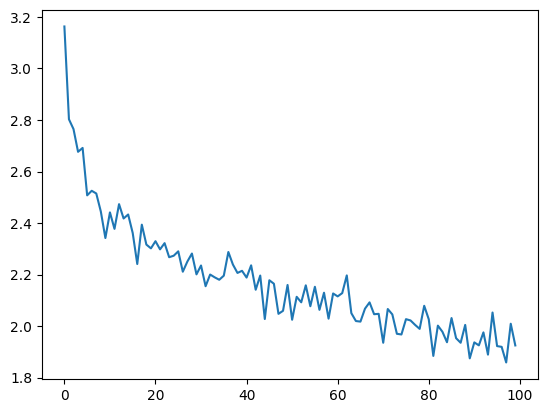

In [153]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(all_losses)
plt.show()

# Evaluating

In [155]:
from torch.nn import Softmax

rnn = RNN(input_size=N_LETTERS,
          hidden_size=128,
          output_size=N_LETTERS,
          n_categories=n_categories,
          num_recurrent_layers=3)
rnn.load_state_dict(torch.load('data/rnn_gen.pt'))
max_length = 20

from torch.nn import Softmax
# Sample from a category and starting letter
def sample(rnn, category, start_letter='A', temperature=0.8):
    with torch.no_grad():
        category_idx = all_categories.index(category)   # pick the index of the category

        # make one-hot of category
        category_tensor = torch.zeros(1, n_categories)
        category_tensor[0][category_idx] = 1

        input = line_to_tensor(start_letter)
        hidden = rnn.init_hidden()

        output_name = start_letter  # initialize the output string
        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)

            # obtain the probability distribution over the alphabet
            probs = Softmax(dim=1)(output / temperature)

            # instead of picking the argmax here we sample from the probability
            # distribution to obtain more variability in the generation
            next_char = torch.multinomial(probs, num_samples=1)

            # here next char is a tensor of shape (1, 1)
            # we pick the item and compare the predicted index with the index of the EOS character
            if next_char.item() == letter_to_index(EOS):
                break   # break if the model predicted the EOS
            else:
                letter = ALL_LETTERS[next_char]
                output_name += letter
            input = line_to_tensor(letter)

        check = 'NEW' if output_name not in category_lines[category] else 'EXISTING'
        print(f"{output_name} ({check})")
        return output_name

a = sample(rnn, 'Italian', start_letter='A')

Arrini (NEW)


In [156]:
def samples(rnn, category, start_letters):
    print("### Category: ", category)
    for start_letter in start_letters:
        sample(rnn, category, start_letter=start_letter)

samples(rnn, 'Italian', 'ABC')
samples(rnn, 'English', 'ABC')
samples(rnn, 'Chinese', 'ABC')
samples(rnn, 'Russian', 'ABC')

### Category:  Italian
Astinina (NEW)
Bagao (NEW)
Candan (NEW)
### Category:  English
And (NEW)
Babhirss (NEW)
Caar (NEW)
### Category:  Chinese
Ang (EXISTING)
Bung (NEW)
Chu (EXISTING)
### Category:  Russian
Ajtin (NEW)
Barann (NEW)
Cammon (NEW)
